**Connect to Elasticsearch**

In [1]:
from pprint import pprint 
from elasticsearch import Elasticsearch

es = Elasticsearch("http://localhost:9200")

client_info = es.info()

print("Connected to Elasticsearch!")

pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'T1HeaWnRTOqX_BBgREVVbA',
 'name': '64c49e436740',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-10-21T10:06:21.288851013Z',
             'build_flavor': 'default',
             'build_hash': '25d88452371273dd27356c98598287b669a03eae',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '10.3.1',
             'minimum_index_compatibility_version': '8.0.0',
             'minimum_wire_compatibility_version': '8.19.0',
             'number': '9.2.0'}}


**ILM Policy**

In [2]:
# ILM = Index Lifecycle Management (ILM)
ilm_policy = {
    "phases": {
        "hot": {
            "actions": {
                "rollover": {
                    # threshold
                    "max_age": "5m",
                    "max_size": "500mb",
                }
            }
        },
        "delete": {
            "min_age": "20m",
            "actions": {
                "delete": {}
            }
        }
    }
}

response = es.ilm.put_lifecycle(name="cpu_usage_policy_v3", policy=ilm_policy)
pprint(response.body)

{'acknowledged': True}


**ILM Template**

In [5]:
body = {
    "index_patterns": ["cpu_usage_template_v3*"], # Match indices or data stream start with index_patterns
    "data_stream": {}, # enable data_stream support 
    "priority": 500, # Higher priority than system template
    "template": {
        "settings": {
            "index.mode": "time_series", # Enable TSDS (Time Series Data Stream) mode
            "index.lifecycle.name": "cpu_usage_policy_v3",
        },
        "mappings": {
            "properties": {
                "@timestamp": {
                    "type": "date"
                },
                "cpu_usage": {
                    "type": "float", 
                    "time_series_metric": "gauge"
                },
                "cpu_name": {
                    "type": "keyword",
                    "time_series_dimension": True # Dimension to group metrics (like per CPU core)
                }
            }
        }
    },
    "_meta": {
        "description": "Template v3 for cpu usage example data."
    },
    "allow_auto_create": True,
}

response = es.indices.put_index_template(
    name="cpu_usage_template_v3",
    body=body
)

pprint(response.body)

{'acknowledged': True}


In [32]:
import  psutil
from datetime import datetime, timezone

import platform
cpu_name = "_".join(platform.processor().split(" ")[0:5])

while True:
    document = {
        "@timestamp": datetime.now(timezone.utc),
        "cpu_usage": psutil.cpu_percent(interval=0.1),
        "cpu_name": cpu_name
    }

    es.index(index="cpu_usage_template_v3", body=document)

KeyboardInterrupt: 

In [33]:
count = es.count(index="cpu_usage_template_v3")['count']
count

482

In [34]:
result = es.search(
    index="cpu_usage_template_v3",
    body={
        "query": {
            "match_all": {}
        },
        "size": 1000
    }
)

In [35]:
hits = result.body["hits"]["hits"]
len(hits)

482

In [36]:
cpu_usage_values = [hit["_source"]["cpu_usage"] for hit in hits]
timestamp_values = [hit["_source"]["@timestamp"] for hit in hits]


**Plot the time series data**

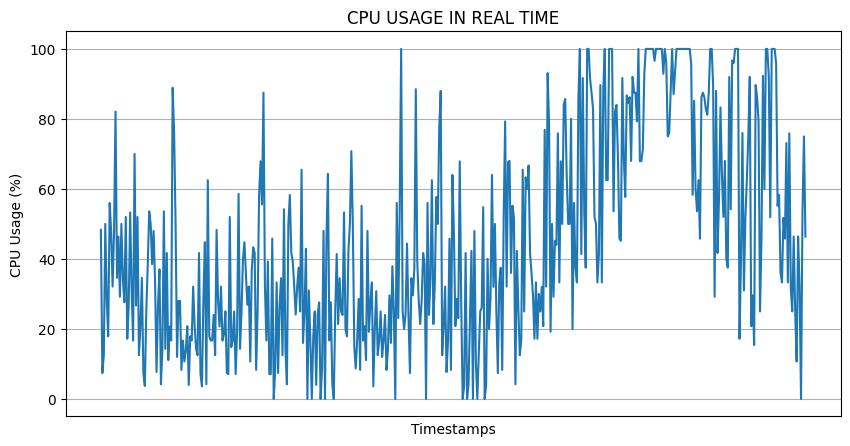

In [37]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 5))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel("Timestamps")
plt.ylabel("CPU Usage (%)")
plt.title("CPU USAGE IN REAL TIME")
plt.grid(True)

plt.show()

**Aggregations**

In [39]:
response = es.search(
    index="cpu_usage_template_v3",
    body={
        "aggs": {
            "avg_cpu_usage_shamim": {
                "avg": {
                    "field": "cpu_usage"
                }
            }
        }
    }
)

average_cpu_usage = response.body["aggregations"]["avg_cpu_usage_shamim"]["value"]
print(f"Average CPU usage: {average_cpu_usage}%")

Average CPU usage: 45.41825723994322%


In [41]:
response = es.search(
    index="cpu_usage_template_v3",
    body={
        "aggs": {
            "max_cpu_usage_shamim": {
                "max": {
                    "field": "cpu_usage"
                }
            }
        }
    }
)

max_usage = response.body["aggregations"]["max_cpu_usage_shamim"]["value"]
print(f"Max cpu usage is {max_usage}%")

Max cpu usage is 100.0%


**Monitoring the index lifecycle**

In [42]:
response = es.indices.get_data_stream()

pprint(response.body)

{'data_streams': [{'_meta': {'description': 'Template for CPU usage data'},
                   'allow_custom_routing': False,
                   'failure_store': {'enabled': False,
                                     'indices': [],
                                     'rollover_on_write': True},
                   'generation': 3,
                   'hidden': False,
                   'ilm_policy': 'cpu_usage_policy_v2',
                   'index_mode': 'time_series',
                   'indices': [{'ilm_policy': 'cpu_usage_policy_v2',
                                'index_mode': 'time_series',
                                'index_name': '.ds-cpu_example_template-2025.11.07-000002',
                                'index_uuid': 'bXo-juB7QyCqICWDuATbIw',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True}],
                   'mappings': {},
                   'name': 'cpu_example_template',
                

In [44]:
ilm_status = es.ilm.get_lifecycle(name="cpu_usage_policy_v3")
pprint(ilm_status.body)

{'cpu_usage_policy_v3': {'in_use_by': {'composable_templates': ['cpu_usage_template_v3'],
                                       'data_streams': ['cpu_usage_template_v3'],
                                       'indices': ['.ds-cpu_usage_template_v3-2025.11.07-000002',
                                                   '.ds-cpu_usage_template_v3-2025.11.07-000004']},
                         'modified_date': '2025-11-07T12:10:58.181Z',
                         'policy': {'phases': {'delete': {'actions': {'delete': {'delete_searchable_snapshot': True}},
                                                          'min_age': '20m'},
                                               'hot': {'actions': {'rollover': {'max_age': '5m',
                                                                                'max_size': '500mb'}},
                                                       'min_age': '0ms'}}},
                         'version': 1}}


In [46]:
response = es.ilm.explain_lifecycle(
    index=".ds-cpu_usage_template_v3-2025.11.07-000002"
)

pprint(response.body)

{'indices': {'.ds-cpu_usage_template_v3-2025.11.07-000002': {'action': 'complete',
                                                             'action_time_millis': 1762545683848,
                                                             'age': '10.15m',
                                                             'age_in_millis': 609023,
                                                             'index': '.ds-cpu_usage_template_v3-2025.11.07-000002',
                                                             'index_creation_date_millis': 1762519894071,
                                                             'lifecycle_date_millis': 1762545682447,
                                                             'managed': True,
                                                             'phase': 'hot',
                                                             'phase_execution': {'modified_date_in_millis': 1762517458181,
                                                     